In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [50]:
num_points = 400
side_length = 10**3
N = 6  # Виленский

x_coords = np.random.uniform(0, side_length, num_points)
y_coords = np.random.uniform(0, side_length, num_points)

points = list(zip(x_coords, y_coords))

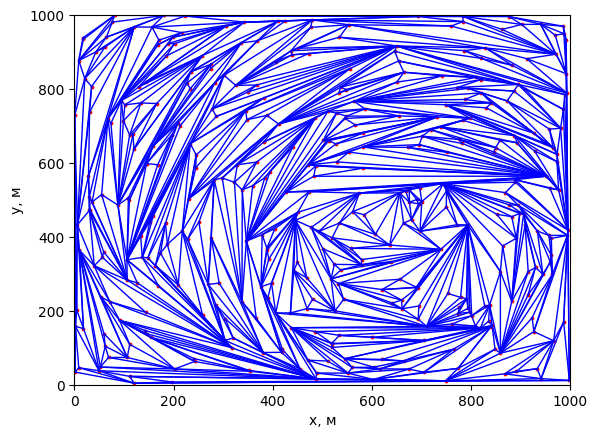

In [54]:
def is_point_upper_line(point, line):
    assert(line[1][0] != line[0][0])
    return (
        point[1] >=
        (point[0] - line[0][0]) / (line[1][0] - line[0][0])
        * (line[1][1] - line[0][1]) + line[0][1]
    )

def sqr_dist_between_points(point1, point2):
    return (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

def sqr_dist_from_point_to_line(point, line):
    (x0, y0), ((x1, y1), (x2, y2)) = point, sorted(line)

    line_dist = sqr_dist_between_points((x1, y1), (x2, y2))
    assert(line_dist != 0)

    # Укорочение линии для изключения неоднозначных ситуаций 
    x1 -= (x1 - x2) * abs(x1 - x2) / line_dist * 1e-10
    y1 -= (y1 - y2) * abs(y1 - y2) / line_dist * 1e-10
    x2 -= (x2 - x1) * abs(x2 - x1) / line_dist * 1e-10
    y2 -= (y2 - y1) * abs(y2 - y1) / line_dist * 1e-10

    projection = (
        (y2 - y1) * ((y0 - y1) * (x2 - x1) - (x0 - x1) * (y2 - y1)) / line_dist + x0,
        (x2 - x1) * ((x0 - x1) * (y2 - y1) - (y0 - y1) * (x2 - x1)) / line_dist + y0
    )

    if projection[0] > x2:
        return sqr_dist_between_points((x0, y0), (x2, y2))
    if projection[0] < x1:
        return sqr_dist_between_points((x0, y0), (x1, y1))
    return sqr_dist_between_points((x0, y0), projection)

def is_positive_angle_between_three_points(point1, point2, point3):
    return is_point_upper_line(point3, (point1, point2)) != (point1[0] > point2[0])

def draw():
    for (x1, y1), (x2, y2) in edges:
        plt.plot((x1, x2), (y1, y2), linewidth=1, color='blue')

    plt.scatter(x_coords, y_coords, s=3, color='red')

    plt.xlim(0, side_length)
    plt.ylim(0, side_length)
    plt.xlabel('x, м')
    plt.ylabel('y, м')

    plt.show()


first_edge = (points[0], min(
    points[1:],
    key=lambda point: sqr_dist_between_points(points[0], point)
))

edges = {first_edge}

# У начального ребра две свободные стороны
outline = [first_edge, first_edge[::-1]]

# Расстояния от неиспользованных точек до фигуры
dists_points_to_outline = {
    point: (edge, sqr_dist_from_point_to_line(point, edge))
    for edge in outline
    for point in points if point not in first_edge
}

draw()

while len(dists_points_to_outline) != 0:
    nearest_point = min(dists_points_to_outline, key=lambda point: dists_points_to_outline[point][1])
    
    # Побдираем ближайшую грань из перимерта
    min_dist_edge = dists_points_to_outline[nearest_point][0]

    # Добавляем новые ребра в общий учет
    new_egde_first = (min_dist_edge[0], nearest_point)
    new_egde_second = (nearest_point, min_dist_edge[1])

    min_dist_edge_index = outline.index(min_dist_edge)
    outline.pop(min_dist_edge_index)
    outline.insert(min_dist_edge_index, new_egde_second)
    outline.insert(min_dist_edge_index, new_egde_first)
    
    edges.add(new_egde_first)
    edges.add(new_egde_second)

    del dists_points_to_outline[nearest_point]
    for point in dists_points_to_outline:
        dists_points_to_outline[point] = min(
            dists_points_to_outline[point],
            (new_egde_first, sqr_dist_from_point_to_line(point, new_egde_first)),
            (new_egde_second, sqr_dist_from_point_to_line(point, new_egde_second)),
            key=lambda edge_and_dist: edge_and_dist[1] + (1e+10 if edge_and_dist[0] not in outline else 0)
        )

    # Восстанавливаем выпуклость фигуры
    current_angle_sign = is_positive_angle_between_three_points(
        min_dist_edge[1], nearest_point, min_dist_edge[0]
    )
    first_outline_point = min_dist_edge[0]
    second_outline_point = next(filter(lambda edge: edge[1] == first_outline_point, outline))[0]
    while (
        current_angle_sign != is_positive_angle_between_three_points(
            nearest_point, first_outline_point, second_outline_point
        )
    ):
        # clear_output(wait=True)
        # draw()

        new_edge = (second_outline_point, nearest_point)

        old_edge_index = outline.index((second_outline_point, first_outline_point))
        outline.pop(old_edge_index)
        outline.insert(old_edge_index, new_edge)
        outline.remove((first_outline_point, nearest_point))

        edges.add(new_edge)

        for point in dists_points_to_outline:
            dists_points_to_outline[point] = min(
                dists_points_to_outline[point],
                (new_edge, sqr_dist_from_point_to_line(point, new_edge)),
                key=lambda edge_and_dist: edge_and_dist[1] + (1e+10 if edge_and_dist[0] not in outline else 0)
            )

        first_outline_point = second_outline_point
        second_outline_point = next(filter(lambda edge: edge[1] == second_outline_point, outline))[0]
    
    current_angle_sign = is_positive_angle_between_three_points(
        min_dist_edge[0], nearest_point, min_dist_edge[1]
    )
    first_outline_point = min_dist_edge[1]
    second_outline_point = next(filter(lambda edge: edge[0] == first_outline_point, outline))[1]
    while (
        current_angle_sign != is_positive_angle_between_three_points(
            nearest_point, first_outline_point, second_outline_point
        )
    ):
        # clear_output(wait=True)
        # draw()

        new_edge = (nearest_point, second_outline_point)

        old_edge_index = outline.index((first_outline_point, second_outline_point))
        outline.pop(old_edge_index)
        outline.insert(old_edge_index, new_edge)
        outline.remove((nearest_point, first_outline_point))

        edges.add(new_edge)

        for point in dists_points_to_outline:
            dists_points_to_outline[point] = min(
                dists_points_to_outline[point],
                (new_edge, sqr_dist_from_point_to_line(point, new_edge)),
                key=lambda edge_and_dist: edge_and_dist[1] + (1e+10 if edge_and_dist[0] not in outline else 0)
            )

        first_outline_point = second_outline_point
        second_outline_point = next(filter(lambda edge: edge[0] == second_outline_point, outline))[1]

    # clear_output(wait=True)
    # draw()

clear_output(wait=True)
draw()